In [1]:
from glob import glob
import os
from scipy.io import loadmat
from scipy import signal,stats
import pandas as pd
import numpy as np
from numpy.fft import fft , ifft
import pywt
import matplotlib.pyplot as plt 
import re
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_selection import RFE
import tensorflow as tf
from tensorflow import keras 
from keras.utils import to_categorical
#import mne

#from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,corrmap)

2023-10-24 16:46:05.030985: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-24 16:46:05.485260: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-24 16:46:06.974647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [93]:
map_label = [
        {'shoroT1':0,'balaT1':1,'paeinT1':2,'raastT1':3,'chapT1':4,'jeloT1':5,'aqabT1':6,'payanT1':7},
        {'shoroT2':0,'balaT2':1,'paeinT2':2,'raastT2':3,'chapT2':4,'jeloT2':5,'aqabT2':6,'payanT2':7},
        {'shoroT3':0,'balaT3':1,'paeinT3':2,'raastT3':3,'chapT3':4,'jeloT3':5,'aqabT3':6,'payanT3':7},          
]

def filter_noisy_data(data,channel_num,sample_for_data,fs,f_nyq,f_low,f_high):
    
    '''
        در این تابع تمام کارهای فیلتر کردن سیگنال انجام می‌شود.
          به منظور پیاده سازی روند فیلترینگ سیگنال، از فیلتر باترورث پیوسته استفاده شده است که معمولا از نوع میان گذر آن استفاده شده است. 
    '''
    
    data_filter = np.zeros_like(data)
    Wn = [f_low,f_high]/np.float_(f_nyq)
    order_filter = 4
    (b,a) = signal.butter(order_filter, Wn, btype='bandpass', output='ba')

    for channel_signal in range(0,channel_num):
        
        '''
         در این قسمت چون سیگنال ما از ۲۱ کانال گرفته شده است هر کدام از کانال ها را فیلتر می‌کنیم.
         سپس یک فور میزنیم به طول تعداد کانال ها.
         بعد دیتای فیلتر شده را درون یک ماتریس صفر که از قبل تعریف کرده ایم می‌ریزیم.
        '''
        
        data_each_channel = data[channel_signal,:]
        data_filter[channel_signal,:] = signal.filtfilt(b,a,data_each_channel)

    return data_filter





#برای استخراج ویژگی آماری از این تابع استفاده می‌کنیم.
def statistical_features(data_for_feature_extraction):
    
    MEAN = np.mean(data_for_feature_extraction)
    VAR = np.var(data_for_feature_extraction)
    ptp = np.ptp(data_for_feature_extraction)
    minim = np.min(data_for_feature_extraction)
    maxim = np.max(data_for_feature_extraction)
    rms = np.sqrt(np.mean(data_for_feature_extraction**2))
    #abs_diff_signal = np.sum(np.abs(np.diff(x)))
    
    POWER = np.mean(np.power(data_for_feature_extraction,2))
    SKEW = stats.skew(data_for_feature_extraction)
    KUR = stats.kurtosis(data_for_feature_extraction) 
    
    return (MEAN,VAR,ptp,minim,maxim,rms,POWER,SKEW,KUR)






def time_feature_selection(data,channel_num):
    '''
        داخل آرگومان اول تابع دیتای هر ۵ باند وجود دارد که میتوانیم یکی یکی آن را دریافت کنیم بعد فیچرهای هر کانال هر باند را درون یک ماتریس 
        ذخیره کنیم که در نهایت یک تنسور ۵*۲۱*۵ داریم که ۵ اول تعداد باندهاس،۲۱ تعداد کانال، ۵ تعداد فیچرهای استخراجی می‌باشد.
         ماتریس اول داخل تنسور فیچرهای اسخراج شده از باند دلتا برای ۲۱ کانال است که یک ماتریس ۲۱* ۵ میشه که ۵ تعداد فیچرهای استخراجی می‌باشد و غیره       
    '''
    
    num_feature = 9 #mean var power skew kur 
    time_feature_selections_total_bands = np.zeros((channel_num,num_feature))


        
    for i in range(0,channel_num):
        data_for_feature_extraction = data[i,:]
    
        time_feature_selections_total_bands[i,:] = statistical_features(data_for_feature_extraction)
        

    return time_feature_selections_total_bands
    


def seperate_band(data,channel_num,sample_for_data,fs,f_nyq):
    #در حوزه زمان ریتم های سیگنال را استخراج می‌کنیم
    #یک ماتریس مثلا ۲۱*۳۹۰۰ که همش سیگنال های باند دلتا را دارد
    #برای هر کانال باندهای آن را استخراج می‌کنیم.
    delta = filter_noisy_data(data,channel_num,sample_for_data,fs,f_nyq,f_low=1,f_high=4)
    
    #یک ماتریس مثلا ۲۱*۳۹۰۰ که همش سیگنال های باند تتا را دارد
    theta = filter_noisy_data(data,channel_num,sample_for_data,fs,f_nyq,f_low=4,f_high=8)
    
    #یک ماتریس مثلا ۲۱*۳۹۰۰ که همش سیگنال های باند آلفا را دارد     
    alpha = filter_noisy_data(data,channel_num,sample_for_data,fs,f_nyq,f_low=8,f_high=12)

    #یک ماتریس مثلا ۲۱*۳۹۰۰ که همش سیگنال های باند بتا را دارد
    beta = filter_noisy_data(data,channel_num,sample_for_data,fs,f_nyq,f_low=12,f_high=30)

    #یک ماتریس مثلا ۲۱*۳۹۰۰ که سیگنال های باند گاما در هر کانال را دارد
    gamma = filter_noisy_data(data,channel_num,sample_for_data,fs,f_nyq,f_low=30,f_high=40)

    return (delta,theta,alpha,beta,gamma)





#از این تابع برای تبدیل فوریه گرفتن از سیگنال استفاده می‌کنیم.
def frequency_domain(data):
    #در این قسمت می‌خوایم از سیگنال تبدیل فوریه بگیریم و برای هر کانال این کار را می‌کنیم..
    N = data.shape[1]
    channel_num = data.shape[0]
    matrix_for_save_fft_each_channel = np.zeros_like(data)
    
    for i in range(0,channel_num):
        #به ازای هر کانال یک سیگنال یک اف اف تی می‌گیریم.
        fft_data = fft(data[i,:],N)
        matrix_for_save_fft_each_channel[i,:] = fft_data
    #خروجی: تبدیل فوریه هر ۲۱ کانال در یک ماتریس به طول سیگنال ورودی 
    return matrix_for_save_fft_each_channel


def feature_selection_frequency(data):
    
    N = data.shape[1]
    channel_num = data.shape[0]
    fs = 2000
    f_r = np.linspace(0,fs/2,int(np.floor(N/2)))
    f_r_total = np.concatenate((f_r,f_r[::-1]))

    num_feature = 9 #mean var power skew kur 
    
    feature_selections_total = np.zeros((channel_num,num_feature)) #number_f_bands = 5
    
    for ch_num in range(channel_num):
        #اطلاعات باند فرکانسی یک کانال

        bands_range_frequency = np.abs(data[ch_num,:int(np.floor(N/2))])

        feature_selections_total[ch_num,:] = statistical_features(bands_range_frequency)

        #f_r = f_r[f_r<40]
        #plt.stem(f_r,bands_range_frequency[:len(f_r)])
        #plt.show()

    return feature_selections_total

def feature_selectin_wavelet(data,channel_num):
    original_sfreq = 2000
    target_sfreq = 120
    resampling_factor = original_sfreq/target_sfreq
    wavelet = 'db6'
    level = 4
    
    number_of_bands = 5
    number_featuers = 9
    wavelete_feature_extractions = np.zeros((number_of_bands, channel_num, number_featuers))
    for i in range(channel_num):
        
        resampled_eeg_data = signal.resample(data[i,:],int(len(data[i,:])/resampling_factor))
        
        #(a4,d4,d3,d2,d1)
        #(delta,theta,alpha,beta,gamma)
        bands = pywt.wavedec(resampled_eeg_data, wavelet, mode='symmetric', level=level)
        
    #     for index,band in enumerate(bands):
    #         wavelete_feature_extractions[index,i,:] = statistical_features(band)
    # return wavelete_feature_extractions
        
def read_raw_data(path):
    
    fs = 2000
    f_nyq = fs/2
    
    Temp = loadmat(path)
    a = 7e-7
    data = Temp['EEG_Data']
    
    #determine the label for data
    re_for_get_label=re.findall(r'ID.*event_id',str(Temp['Labels'][0]))[0].split(",")[0]
    re_for_get_label=re_for_get_label.split(':')[1].strip()
    label_for_subject_t = re_for_get_label.replace("'",'')

    #determine channel number eeg signal i
    channel_num = data.shape[0]
    #determine sample number for eeg signal i
    sample_for_data = data.shape[1]
    
    ####################################################denoising data 
    #determine 8 - 30 hz

    data_denoising = filter_noisy_data(data, channel_num, sample_for_data, fs, f_nyq, f_low=8,f_high=30)

    #از این به بعد این دیتای دینویز را برای اسخراج ویژگی به توابع می‌فرستیم
    #####################################################seperate frequency band
    #(delta_time,theta_time,alpha_time,beta_time,gamma_time) = seperate_band(data_denoising,channel_num,sample_for_data,fs,f_nyq)
    
    #####################################################Time Feature Extraction
    time_feature_selection_for_entire_band = time_feature_selection(data_denoising,channel_num)
    
    ############################################################frequency domain + frequency Feature Extraction
    #تبدیل فوریه داده دینویز شده
    change_time_domain_to_frequency_domain_data = frequency_domain(data_denoising)
    #استخراج ویژگی از حوزه فرکانس
    frequency_feature_selection_for_entire_bands = feature_selection_frequency(change_time_domain_to_frequency_domain_data)
    
    #استخراج ویژگی از حوزه ویولت
    #wavelet_feature_selection_for_entire_bands = feature_selectin_wavelet(data_denoising,channel_num)
    
    return label_for_subject_t, time_feature_selection_for_entire_band,frequency_feature_selection_for_entire_bands

In [95]:
path_os = os.getcwd()
PATH = os.path.join(path_os,'data','v1')
for subject in range(1,7):
    subject_T = glob(PATH+f'/s{subject}/Directions_and_Time_T{1}/*.mat')
    Path_for_save = PATH+f'/s{subject}/Directions_and_Time_T{1}/FetureExtraction/'
    
    num_fetures = 9
    total_features = 25
    chan_numbers = 21 #channel numbers
    bands_numbers = 5
    
    data_for_network1 = np.zeros((len(subject_T),chan_numbers*num_fetures))
    data_for_network2 = np.zeros((len(subject_T),chan_numbers*num_fetures))
    label_y = []
    
    for index,data_raw_path in enumerate(subject_T):
          
    
        label,TFE,FFE = read_raw_data(data_raw_path)
    
        '''
            فیچرهای که استخراج کردیم به صورت یک تنسور می‌باشد که هر ماتریس آن اطلاعات یک باند فرکانسی است مثلا ماتریس اول شامل ۲۱ سطر است
            و ۵ ستون که به معنی اطلاعات اسخراج شده ۲۱ کانال است
            الان میخوایم اطلاعات ۵ باند را برای هر کانال پشت سر هم قرار بدهیم..
            
            TFE = Time Feature Extraction
            FFE = Frequency Feature Extraction
            WFE = wavelet Feature Extraction
    
        '''
        
        if ("T1" in label):
            label_y.append(map_label[0].get(label))
        elif ("T2" in label):
            label_y.append(map_label[1].get(label))
        elif ("T3" in label):
            label_y.append(map_label[2].get(label))


        data_for_network1[index,:] = np.ravel(TFE)
        data_for_network2[index,:] = np.ravel(FFE)
        #concat = np.concatenate((data_for_network1,data_for_network2),axis=1)
        
    np.save(Path_for_save+f"TFE-{subject}",data_for_network1)
    np.save(Path_for_save+f"FFE-{subject}",data_for_network2)
    np.save(Path_for_save+f"label-{subject}",np.array(label_y))
        # np.save(Path_for_save+"/WFE/"+f"{index}_"+name+"-WFE-"+label,concatenate_WFE_for_each_channel)

/tmp/ipykernel_4684/541540615.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix_for_save_fft_each_channel[i,:] = fft_data


In [96]:
#load data
path_os = os.getcwd()
PATH = os.path.join(path_os,'data','v1')
time_data_total = []
freq_data_total = []
label_total = []
for subject in range(1,7):
    subject_T_TES = PATH+f'/s{subject}/Directions_and_Time_T{1}/FetureExtraction/TFE-{subject}.npy'
    subject_T_FFS = PATH+f'/s{subject}/Directions_and_Time_T{1}/FetureExtraction/FFE-{subject}.npy'
    subject_T_label = PATH+f'/s{subject}/Directions_and_Time_T{1}/FetureExtraction/label-{subject}.npy'
    
    time_data_total.extend(np.load(subject_T_TES))
    freq_data_total.extend(np.load(subject_T_FFS))
    label_total.extend(np.load(subject_T_label))
time_data_total = np.array(time_data_total)
freq_data_total = np.array(freq_data_total)
label_total = np.array(label_total)

In [98]:
time_data_total.shape

(550, 189)

In [100]:
X_train,X_test,y_train,y_test = train_test_split(time_data_total,label_total,test_size=0.2,random_state=42)

MEAN_Train = X_train.mean(axis=1)
STD_Train = np.std(X_train,axis=1)

Mean_train = np.zeros(X_train.shape)
Std_train = np.zeros(X_train.shape)


for i in range(X_train.shape[0]):
    Mean_train[i,:] = np.repeat(MEAN_Train[i],X_train.shape[1])
    Std_train[i,:] = np.repeat(STD_Train[i],X_train.shape[1])
X_train = (X_train - Mean_train)/Std_train

MEAN_Test = X_test.mean(axis=1)
STD_Test = np.std(X_test,axis=1)

Mean_test = np.zeros(X_test.shape)
Std_test = np.zeros(X_test.shape)

for i in range(X_test.shape[0]):
    Mean_test[i,:] = np.repeat(MEAN_Test[i],X_test.shape[1])
    Std_test[i,:] = np.repeat(STD_Test[i],X_test.shape[1])
X_test = (X_test - Mean_test)/Std_test

In [83]:
y = np.array(label_y)

In [101]:
y = to_categorical(label_total,num_classes=8)
model = keras.Sequential()
model.add(keras.layers.Dense(64,input_dim=X_train.shape[1],activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dense(8,activation='softmax'))
# model.compile(loss='categorical_crossentropy',optimizer='adam',matrics=['accuracy'])
model.compile(optimizer="Adam", loss="mse", metrics=["mae", "acc"])

In [102]:
model.fit(X_train,y_train,epochs=1000,batch_size=32)

Epoch 1/1000
14/14 [==============================] - 1s 3ms/step - loss: 15.8285 - mae: 3.3108 - acc: 0.1205
Epoch 2/1000
14/14 [==============================] - 0s 3ms/step - loss: 15.8243 - mae: 3.3108 - acc: 0.1182
Epoch 3/1000
14/14 [==============================] - 0s 3ms/step - loss: 15.8238 - mae: 3.3108 - acc: 0.1432
Epoch 4/1000
14/14 [==============================] - 0s 3ms/step - loss: 15.8237 - mae: 3.3108 - acc: 0.1386
Epoch 5/1000
14/14 [==============================] - 0s 3ms/step - loss: 15.8237 - mae: 3.3108 - acc: 0.1636
Epoch 6/1000
14/14 [==============================] - 0s 3ms/step - loss: 15.8237 - mae: 3.3108 - acc: 0.1432
Epoch 7/1000
14/14 [==============================] - 0s 3ms/step - loss: 15.8236 - mae: 3.3108 - acc: 0.1500
Epoch 8/1000
14/14 [==============================] - 0s 3ms/step - loss: 15.8236 - mae: 3.3108 - acc: 0.1432
Epoch 9/1000
14/14 [==============================] - 0s 3ms/step - loss: 15.8236 - mae: 3.3108 - acc: 0.1318
Epoch 10/1

In [103]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)


4/4 [==============================] - 0s 3ms/step


In [104]:
accuracy_ = accuracy_score(np.argmax(y_pred,axis=1),y_test)
class_report = classification_report(np.argmax(y_pred,axis=1),y_test)

/home/payam/Documents/PYTHON/EEG/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/payam/Documents/PYTHON/EEG/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/payam/Documents/PYTHON/EEG/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
from sklearn import metrics


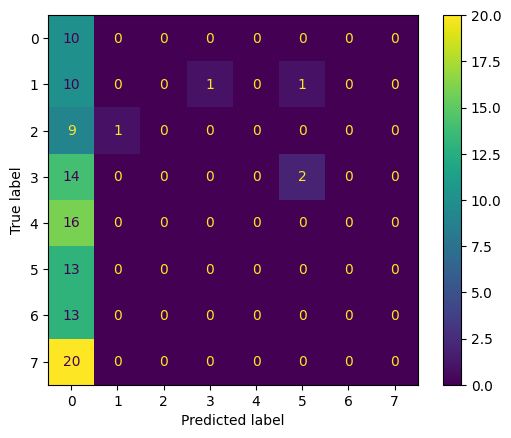

In [105]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_classes)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [91]:
confusion_matrix

array([[ 0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  1,  0,  0,  8,  1],
       [ 0,  0,  0,  0,  0,  0, 16,  0],
       [ 0,  0,  0,  0,  0,  0, 16,  0],
       [ 0,  0,  0,  0,  0,  1, 12,  0],
       [ 0,  0,  0,  0,  0,  0, 13,  0],
       [ 0,  0,  0,  0,  0,  0, 20,  0]])

In [106]:
accuracy_*100

9.090909090909092